<a href="https://www.kaggle.com/code/jollychappies/neural-network-from-scratch-using-numpy?scriptVersionId=185799806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# read csv
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# get feature data
X_train = train.drop(columns=['label']).transpose()

# get target variables
y_train = train['label']

# convert to numpy arrays
train = train.to_numpy()
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
test = test.to_numpy().transpose()

After recently completing Andrew Ng's course on Neural Networks and Deep Learning, I thought I'd implement what I've learned for this competition.

# Neural network from scratch.

The steps required to build and train a neural network are:

1. Define layer architecture
2. Initialise parameters
3. Forward propagation
4. Compute cost
5. Backward propagation
6. Update parameters

# 1. Define layer architecture

Let's find out how large our input layer must be from the number of pixels in an image.

In [3]:
X_train.shape[0]

784

In [4]:
layer_dims = [784, 20, 15, 10]

# 2. Initialise parameters

In [5]:
def initialise_parameters(layer_dims):
    
    # number of layers
    L = len(layer_dims)
    
    # initialise params dictionary
    parameters = dict()
    
    # cycle through layers and initialise parameters
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

parameters = initialise_parameters(layer_dims)

# 3. Forward propagation

In [6]:
def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b

    cache = (A, W, b)
    return Z, cache

In [7]:
def ReLU(Z):
    
    relu = np.maximum(0, Z)
    
    return relu

In [8]:
def sigmoid(Z):
    
    sigmoid = np.divide(1, 1+np.exp(-Z))
    
    return sigmoid

In [9]:
# def softmax(Z):
    
#     softmax = np.exp(Z)/np.sum(np.sum(Z))
    
#     return softmax

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    
    # compute Z
    Z, linear_cache = linear_forward(A_prev, W, b)
        
    # compute A
    if activation == 'relu':
        A = ReLU(Z)
    elif activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'softmax':
        A = softmax(Z)
    
    # caches
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [11]:
# testing
parameters = initialise_parameters(layer_dims)
A, cache = linear_activation_forward(X_train, parameters['W1'], parameters['b1'], activation='softmax')

In [12]:
def l_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    
    # find number of layers
    L = len(parameters)//2
    
    # get ready to capture all caches from each layer
    caches = []
    
    # initialise A_prev as X
    A_prev = X
    
    # forward propagation for layers (aside from last)
    for l in range(1, L):
        
        # compute forward linear activation
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation='relu')

        # reset A_prev
        A_prev = A
        
        caches.append(cache)
    
    # forward propagation for last layer
    AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], activation='softmax')
    caches.append(cache)
    
    return AL, caches

In [72]:
AL, caches = l_model_forward(X_train[:,:5], parameters)

# final scores for first 5 training examples
AL

array([[0.10043734, 0.09816342, 0.09985779, 0.100368  , 0.09830082],
       [0.10047614, 0.09973125, 0.10069528, 0.10190497, 0.09858928],
       [0.09982359, 0.09996954, 0.1016143 , 0.10114871, 0.10389063],
       [0.10018377, 0.09900047, 0.09954793, 0.1005564 , 0.0984937 ],
       [0.09845455, 0.10091609, 0.0964003 , 0.09509867, 0.09903717],
       [0.10081104, 0.1009915 , 0.10181348, 0.10313938, 0.10124601],
       [0.1000292 , 0.09894323, 0.09707522, 0.09707375, 0.09379193],
       [0.10080719, 0.1028208 , 0.1046786 , 0.10427823, 0.10618434],
       [0.09988401, 0.10053903, 0.10085571, 0.09934869, 0.10202048],
       [0.09909318, 0.09892468, 0.09746139, 0.0970832 , 0.09844565]])

# 4. Compute cost

In [73]:
def onehot_encoder(array):
    
    ohe = np.zeros((len(array), array.max()+1))
    ohe[np.arange(len(array)), array] = 1
    ohe = ohe.transpose()
    
    return ohe

In [74]:
def compute_cost(AL, y):
    
    # one hot encode y
    y_ohe = onehot_encoder(y)
    
    # number of examples
    m = len(y)
    
    # categorical cross-entropy loss function
    cost = (-1/m) * np.sum(y_ohe * np.log(AL))
    
    return cost

In [76]:
compute_cost(AL, y_train[:5])

2.3104179179081976

In [77]:
def get_predictions(AL):
    predictions = np.argmax(AL, axis=0)
    return predictions

In [78]:
predictions = get_predictions(AL)
predictions

array([5, 7, 7, 7, 7])

In [79]:
def compute_accuracy(predictions, Y):
    
    accuracy = np.sum(predictions==Y)/Y.size
    
    return accuracy

# 5. Backward propagation

In [20]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    
    return dA_prev, dW, db

In [21]:
def linear_activation_backward(dA, cache, Y, activation_function):
    
    linear_cache, activation_cache = cache
    Z = activation_cache
    
    # calculation depends on activation function
    if activation_function=='sigmoid':
        
        dZ = dA * (sigmoid(Z)*(1-sigmoid(Z)))
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation_function=='softmax':
        
        dZ = softmax(Z) - Y
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation_function=='relu':
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [22]:
def l_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ... 
             grads["db" + str(l)] = ... 
    """
    
    # number of layers
    L = len(caches)
    
    # gradient storage
    grads = dict()    
    
    # one hot encode y
    Y_ohe = onehot_encoder(Y)
    
    # initiate backward propagation
#     print('Y:',Y_ohe)
#     print('AL:', AL)
    dAL = -np.divide(Y_ohe, AL) + np.divide(1-Y_ohe, 1-AL)
    
    # propagate backwards through last layer separately (as it has a different activation function)
    current_cache = caches[L-1]
#     print('layer:', L)
    grads['dA'+str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = linear_activation_backward(dAL, current_cache, Y_ohe, activation_function='softmax')
    
    # cycle through layers in reverse
    for l in reversed(range(1, L)):
        current_cache = caches[l-1]
#         print('layer:', l)
        grads['dA'+str(l-1)], grads['dW'+str(l)], grads['db'+str(l)] = linear_activation_backward(grads['dA'+str(l)], current_cache, Y_ohe, activation_function='relu')
        
    return grads

# 6. Update parameters

In [23]:
def update_parameters(params, grads, learning_rate):
    
    L = len(params)//2
        
    # cycle through each layer and change parameters
    for l in range(1, L+1):
        params['W'+str(l)] = params['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        params['b'+str(l)] = params['b'+str(l)] - learning_rate * grads['db'+str(l)]
        
    return params

# 7. Putting it all together

In [24]:
def l_layer_model(X, Y, layers_dim, learning_rate=0.001, num_iterations=100, print_cost=True):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # initialise parameters
    params = initialise_parameters(layers_dim)
#     print('Initial W3:', params['W3'], params['W3'].shape)

    # repeat for number of iterations
    for i in range(0, num_iterations):

        # forward propagation
        AL, caches = l_model_forward(X, params)

        # compute cost - TRY REPLACING WITH PYTORTH EQUIVALENT
        cost = compute_cost(AL, Y)

        # backward propagation
        grads = l_model_backward(AL, Y, caches)
#         print(grads)
        
        # update parameters
        params = update_parameters(params, grads, learning_rate)
#         print(params)
                
        # get predictions
        predictions = get_predictions(AL)
        accuracy = compute_accuracy(predictions, Y)
        # print cost if required
        if print_cost==True and i%10==0:
            print('Iteration',i,'- cost:', cost)
            print('Accuracy:', accuracy)
    
    return params

In [25]:
model_params = l_layer_model(X_train, y_train, [784, 15, 10])

Iteration 0 - cost: 2.563614835226048
Accuracy: 0.11902380952380952
Iteration 10 - cost: 1.716749477720245
Accuracy: 0.4903571428571429
Iteration 20 - cost: 1.1856021685176998
Accuracy: 0.6793333333333333
Iteration 30 - cost: 0.8610170403972757
Accuracy: 0.7602619047619048
Iteration 40 - cost: 0.7046903144654633
Accuracy: 0.7941428571428572
Iteration 50 - cost: 0.620289631872739
Accuracy: 0.8155
Iteration 60 - cost: 0.5666639255037882
Accuracy: 0.8302380952380952
Iteration 70 - cost: 0.5290612121371051
Accuracy: 0.8415238095238096
Iteration 80 - cost: 0.5009864108261992
Accuracy: 0.8507380952380953
Iteration 90 - cost: 0.4790268429458978
Accuracy: 0.8579761904761904


In [26]:
def predict(X, parameters):
    
    # get scores after forward prop
    AL, _ = l_model_forward(X, parameters)
    
    # get predictions
    predictions = get_predictions(AL)
    
    return predictions

def test_prediction(index, parameters):
    
    # get prediction for example
    prediction = predict(X_train[:, [index]], parameters)
    
    # get label
    label = y_train[index]
    
    # show image
    plt.imshow(X_train[:, [index]].reshape(28, 28))
    print('Label:', label)
    print('Prediction:', prediction)
    

In [27]:
predict(X_train[:, [100]], model_params)

array([9])

Label: 1
Prediction: [1]


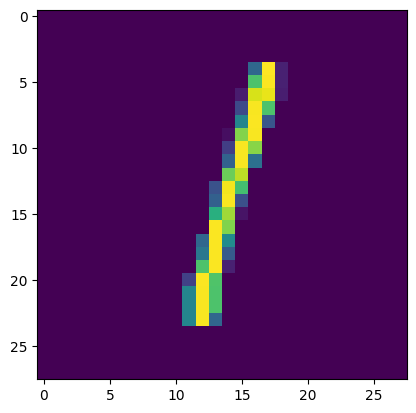

In [28]:
test_prediction(590, model_params)

# Hyperparameter tuning

In [34]:
np.random.seed(42)

# shuffle dataset
indices = np.arange(train.shape[0])
np.random.shuffle(indices)
train_shuffled = train[indices]

# validation ratio
validation_ratio = 0.2

# split index
split_index = int(train_shuffled.shape[0]*(1-validation_ratio))

# split data
train_split = train_shuffled[:split_index]
validation_split = train_shuffled[split_index:]

# split features and target variable
X_train = train_split[:,1:].transpose()
y_train = train_split[:,0].transpose()
X_val = validation_split[:,1:].transpose()
y_val = validation_split[:,0].transpose()

In [37]:
# hyperparameter space
parameter_grid = {
    'layer_dims':[
                [784, 15, 10], # small nn
                [784, 20, 15, 10], # medium nn
                [784, 50, 25, 15, 10] # large nn
    ], 
    'learning_rate':[0.01, 0.001],
    'num_iterations':[250, 100]
}

In [39]:
import itertools

keys, values = zip(*parameter_grid.items())
results = []
for parameter_combo in itertools.product(*values):
    
    # create parameter combination dictionary
    params = dict(zip(keys, parameter_combo))
    print(params)
    
    # train model
    model_params = l_layer_model(X_train, 
                                 y_train,
                                 layers_dim=params['layer_dims'],
                                 learning_rate=params['learning_rate'],
                                 num_iterations=params['num_iterations'],
                                 print_cost=True)
    
    
    # make predictions on the test set
    preds = predict(X_val, model_params)
    
    # get accuracy
    accuracy = compute_accuracy(preds, y_val)
    print(accuracy)
    
    # save results
    result = [params, model_params, accuracy]
    results.append(result)

{'layer_dims': [784, 15, 10], 'learning_rate': 0.01, 'num_iterations': 250}
Iteration 0 - cost: 2.4863953225185442
Accuracy: 0.07172619047619047
Iteration 10 - cost: 2.4585263029278552
Accuracy: 0.2505654761904762
Iteration 20 - cost: 2.122554174685665
Accuracy: 0.17095238095238094
Iteration 30 - cost: 2.2996461460245725
Accuracy: 0.11726190476190476
Iteration 40 - cost: 2.0724583430920807
Accuracy: 0.2051488095238095
Iteration 50 - cost: 2.0917747390391743
Accuracy: 0.11202380952380953
Iteration 60 - cost: 2.074103843704822
Accuracy: 0.2037797619047619
Iteration 70 - cost: 2.0684985594649854
Accuracy: 0.2044642857142857
Iteration 80 - cost: 2.065403477512458
Accuracy: 0.2049404761904762
Iteration 90 - cost: 2.0631370688536927
Accuracy: 0.20535714285714285
Iteration 100 - cost: 2.0612199740253545
Accuracy: 0.20541666666666666
Iteration 110 - cost: 2.059559653184115
Accuracy: 0.2055357142857143
Iteration 120 - cost: 2.0580894776240997
Accuracy: 0.21220238095238095
Iteration 130 - cost: 

In [58]:
# find best accuracy
accuracies = [result[2] for result in results]
best_accuracy_index = np.argmax(accuracies)

# find best params
best_params = results[best_accuracy_index][1]

[{'layer_dims': [784, 20, 15, 10],
  'learning_rate': 0.01,
  'num_iterations': 250},
 {'W1': array([[-0.00529797,  0.00358079, -0.00786706, ..., -0.00507985,
           0.0134123 ,  0.01558699],
         [ 0.00394906, -0.00359972, -0.0120633 , ..., -0.01045295,
          -0.00262962,  0.00068512],
         [-0.0043093 ,  0.00205818, -0.00508573, ...,  0.00975014,
          -0.0050386 ,  0.01956081],
         ...,
         [-0.00288385,  0.00347935,  0.00248177, ...,  0.00336121,
           0.00828989, -0.01997622],
         [-0.01271359,  0.00112289, -0.00665145, ...,  0.00611287,
           0.00077539, -0.00151151],
         [ 0.00052352, -0.02311181,  0.01916934, ...,  0.00349969,
           0.01077255,  0.00146282]]),
  'b1': array([[-1.22517415e-04],
         [-5.56348217e-05],
         [ 1.79088336e-04],
         [ 6.18189536e-05],
         [ 4.05377470e-07],
         [ 4.59168366e-05],
         [ 3.03285404e-05],
         [ 2.78832591e-05],
         [-4.30225752e-06],
         [

In [ ]:
# make predictions on test set
test_preds = predict(test, best_params)

# create submission dataframe
submission = pd.DataFrame(data=
                          {'ImageId':np.arange(1, test.shape[1]+1),
                          'Label':test_preds})

# export dataframe to csv
submission.to_csv('submission.csv', index=False)